In [20]:
from zget_data import get_responses, get_qdetails, get_questions, get_design, page_map, quest_map, attention
from collections import defaultdict
import pandas as pd
import json

In [21]:
page_id = '7'
password_response, time_response, survey_response, dids = get_responses()
questions = get_questions()

Total: 163; 
Attentive: 131; Non Attentive: 32


In [22]:
survey_response_df = pd.DataFrame(survey_response)

quest = pd.json_normalize(survey_response_df[page_id]).astype(float)
quest.drop(attention.get(page_id).keys(), axis=1, inplace=True)
# normalize low and high likert scale values
normqsid = ['1-2', '1-4', '1-7', '1-10', '1-12', '1-13', '1-16']
normquest = 8 - quest[normqsid]
quest.update(normquest)

# normalize scale 1 to 8 to scale -3 to 3
normquest = quest - 4
quest.update(normquest)

new_columns = {}
for qsid in quest.columns:
    likert_scale = 'low' if qsid in normqsid else 'high'
    new_columns[qsid] = json.loads(get_qdetails(page_id, qsid).replace("'", '"')).get('elements').get(likert_scale)
quest.rename(columns=new_columns, inplace=True)

display(quest.head())
display(quest.describe())

,organized,ordered,beneficial,rewarding,well grouped,structured,helpful,clear,useful,appealing,understandable,pleasant,beautiful,easy,stylish,easy to learn
0,-3.0,-3.0,1.0,-1.0,-3.0,-3.0,0.0,-2.0,1.0,-3.0,1.0,-2.0,-3.0,-3.0,-3.0,-2.0
1,2.0,2.0,1.0,-2.0,2.0,2.0,1.0,2.0,1.0,-3.0,2.0,-3.0,-3.0,3.0,-2.0,2.0
2,3.0,3.0,2.0,1.0,3.0,2.0,3.0,3.0,2.0,1.0,3.0,0.0,0.0,3.0,1.0,3.0
3,3.0,3.0,2.0,3.0,2.0,2.0,3.0,-1.0,2.0,2.0,2.0,3.0,1.0,2.0,3.0,3.0
4,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,2.0,3.0,3.0,3.0


,organized,ordered,beneficial,rewarding,well grouped,structured,helpful,clear,useful,appealing,understandable,pleasant,beautiful,easy,stylish,easy to learn
count,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000
mean,1.740458,1.458015,1.480916,0.801527,1.580153,1.778626,1.625954,1.503817,1.320611,1.282443,1.984733,1.061069,0.938931,1.610687,0.755725,1.549618
std,1.173999,1.540527,1.594949,1.619211,1.329859,1.210785,1.448266,1.595060,1.618485,1.442619,1.045023,1.567731,1.368636,1.444206,1.534684,1.499814
min,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-2.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000
25%,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
50%,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000
75%,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000,2.000000,2.000000,3.000000,2.000000,3.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


In [23]:
quest['did'] = dids
did_quest = quest.groupby('did').mean()
did_quest

,organized,ordered,beneficial,rewarding,well grouped,structured,helpful,clear,useful,appealing,understandable,pleasant,beautiful,easy,stylish,easy to learn
did,,,,,,,,,,,,,,,,
1,2.148148,1.851852,1.925926,1.074074,2.037037,2.222222,2.296296,2.148148,1.925926,1.740741,2.444444,1.666667,1.518519,2.037037,1.333333,2.074074
2,1.423077,1.000000,1.384615,0.807692,1.307692,1.653846,1.384615,0.961538,1.230769,1.230769,1.500000,1.192308,1.000000,1.384615,1.000000,1.038462
3,1.961538,1.730769,1.538462,1.192308,1.730769,1.923077,1.884615,1.884615,1.384615,1.230769,1.769231,0.576923,0.615385,1.461538,0.730769,1.576923
4,1.692308,1.307692,1.538462,0.500000,1.538462,1.615385,1.500000,1.384615,1.000000,1.307692,2.230769,1.192308,0.807692,1.730769,0.346154,1.538462
5,1.461538,1.384615,1.000000,0.423077,1.269231,1.461538,1.038462,1.115385,1.038462,0.884615,1.961538,0.653846,0.730769,1.423077,0.346154,1.500000


In [24]:
cats = {}
for k, v in quest_map.items():
    temp = did_quest[v]
    cats[k] = temp.mean(axis=1).to_dict()
cats = pd.DataFrame(cats)

cats.index = cats.index.map(get_design)
cats.index.names = ['design']
cats

,Perspicuity,Aesthetics,Usefulness,Clarity
design,,,,
logos,2.175926,1.564815,1.805556,2.064815
metaphor,1.221154,1.105769,1.201923,1.346154
personal,1.673077,0.788462,1.500000,1.836538
professional,1.721154,0.913462,1.134615,1.538462
consequences,1.500000,0.653846,0.875000,1.394231


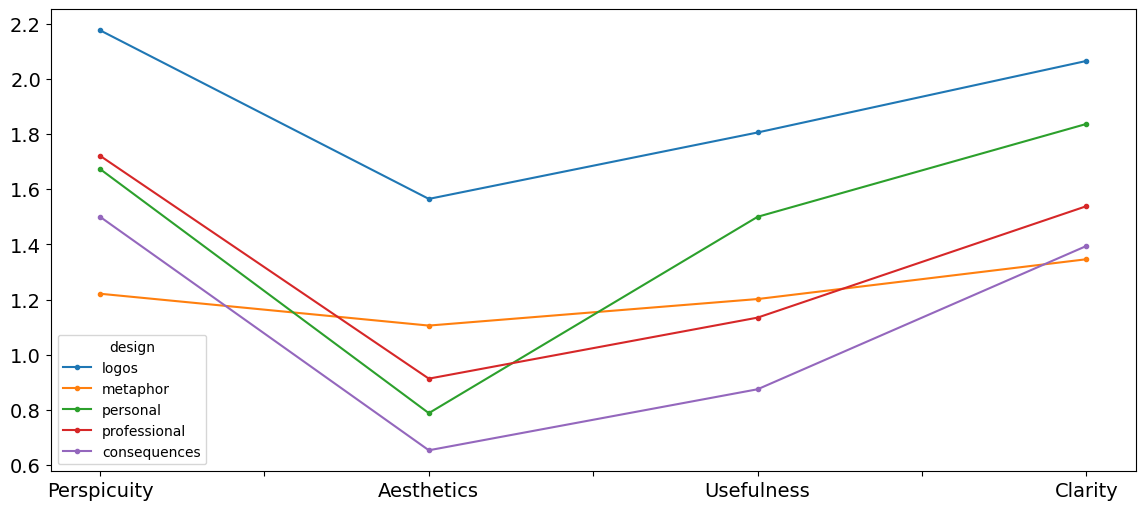

In [29]:
_ = cats.plot(figsize=(14, 6), fontsize=14, style=".-")